In [1]:
library(VennDiagram)
library(tidyverse)
library(RColorBrewer)

Loading required package: grid
Loading required package: futile.logger
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
gwas_df <- read_csv('../data/gwas_catalog/combined.csv')

gwas_df %>% head(2)

Parsed with column specification:
cols(
  .default = col_character(),
  `DATE ADDED TO CATALOG` = col_date(format = ""),
  PUBMEDID = col_double(),
  DATE = col_date(format = ""),
  CHR_POS = col_double(),
  UPSTREAM_GENE_DISTANCE = col_double(),
  DOWNSTREAM_GENE_DISTANCE = col_double(),
  MERGED = col_double(),
  SNP_ID_CURRENT = col_double(),
  INTERGENIC = col_double(),
  `P-VALUE` = col_double(),
  PVALUE_MLOG = col_double(),
  `OR or BETA` = col_double()
)
See spec(...) for full column specifications.


DATE ADDED TO CATALOG,PUBMEDID,FIRST AUTHOR,DATE,JOURNAL,LINK,STUDY,DISEASE/TRAIT,INITIAL SAMPLE SIZE,REPLICATION SAMPLE SIZE,⋯,PVALUE_MLOG,P-VALUE (TEXT),OR or BETA,95% CI (TEXT),PLATFORM [SNPS PASSING QC],CNV,MAPPED_TRAIT,MAPPED_TRAIT_URI,STUDY ACCESSION,GENOTYPING TECHNOLOGY
<date>,<dbl>,<chr>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2019-07-12,31049640,Chen J,2019-05-02,Diabetologia,www.ncbi.nlm.nih.gov/pubmed/31049640,Genome-wide association study of type 2 diabetes in Africa.,Type 2 diabetes,"2,633 African ancestry cases, 1,714 African ancestry controls",NA,⋯,5.397940,NA,1.34,[1.17-1.53],"Affymetrix, Illumina [12148595] (imputed)",N,type II diabetes mellitus,http://www.ebi.ac.uk/efo/EFO_0001360,GCST008114,Genome-wide genotyping array
2019-07-12,31049640,Chen J,2019-05-02,Diabetologia,www.ncbi.nlm.nih.gov/pubmed/31049640,Genome-wide association study of type 2 diabetes in Africa.,Type 2 diabetes,"2,633 African ancestry cases, 1,714 African ancestry controls",NA,⋯,5.045757,NA,1.84,[1.42-2.38],"Affymetrix, Illumina [12148595] (imputed)",N,type II diabetes mellitus,http://www.ebi.ac.uk/efo/EFO_0001360,GCST008114,Genome-wide genotyping array


In [3]:
gwas_df %>%
    select(study = 'STUDY ACCESSION', author = 'FIRST AUTHOR', date = DATE, 
           platform = 'PLATFORM [SNPS PASSING QC]', snp = SNP_ID_CURRENT, 
           p_value = 'P-VALUE', p_value_text = 'P-VALUE (TEXT)') %>%
    mutate(
        population = study %>% recode(
            'GCST008114' = 'African',
            'GCST005047' = 'European',
            'GCST007847' = 'Japanese'
        ),
        probed_snps = platform %>% str_extract('[0-9]+') %>% as.integer
    ) %>%
    group_by(study, population, author, date, platform, probed_snps) %>%
    summarize(
        n_snp_reported = n_distinct(snp),
        n_snp_significant = sum(p_value < 5e-8)
    ) %>%
    ungroup() %>%
    arrange(population)

study,population,author,date,platform,probed_snps,n_snp_reported,n_snp_significant
<chr>,<chr>,<chr>,<date>,<chr>,<int>,<int>,<int>
GCST008114,African,Chen J,2019-05-02,"Affymetrix, Illumina [12148595] (imputed)",12148595,40,2
GCST005047,European,Morris AP,2012-09-01,"Affymetrix, Illumina [up to 2500000] (imputed)",2500000,64,73
GCST007847,Japanese,Suzuki K,2019-02-04,Illumina [12557761] (imputed),12557761,126,103


## Using SNP IDs

[GWAS Catalog documentation](https://www.ebi.ac.uk/gwas/docs/fileheaders) says:

>SNP_ID_CURRENT*: current rs number

In [4]:
snp_df <- gwas_df %>% 
    drop_na(SNP_ID_CURRENT) %>%
    select(study = 'STUDY ACCESSION', SNP_ID_CURRENT, p_value = 'P-VALUE', 
           p_value_desc = 'P-VALUE (TEXT)') %>%
    # Filter out those loci which are conditional on gender
    filter(is.na(p_value_desc) | !str_detect(p_value_desc, 'men|female')) %>%
    group_by(study, SNP_ID_CURRENT) %>%
    filter(p_value == min(p_value)) %>%
    ungroup %>%
    # Apply (somewhat arbitrarily) the conventional threshold for genome-wide significance
    filter(p_value < 5 * 10^-8) %>%
    arrange(SNP_ID_CURRENT)

snp_df %>% head(2)

study,SNP_ID_CURRENT,p_value,p_value_desc
<chr>,<dbl>,<dbl>,<chr>
GCST005047,5215,9e-10,NA
GCST007847,123378,5e-09,NA


In [5]:
# No overlap between all three
snp_df %>%
    pivot_wider(id_cols = SNP_ID_CURRENT, names_from = study, values_from = p_value) %>%
    drop_na(GCST008114, GCST005047, GCST007847) %>%
    nrow %>%
    print

# Pairwise overlaps
snp_df %>%
    drop_na(p_value) %>%
    select(SNP_ID_CURRENT, study) %>%
    table %>%
    crossprod

[1] 0


,GCST005047,GCST007847,GCST008114
GCST005047,39,3,1
GCST007847,3,103,0
GCST008114,1,0,2


## Using chromosome position

[GWAS Catalog documentation](https://www.ebi.ac.uk/gwas/docs/faq) states:

>We use an Ensembl mapping pipeline that provides the genomic annotation (chromosome location, cytogenetic region and mapped genes), alongside the curated content in the GWAS Catalog. The mapping information is updated at every Ensembl release, every 2-3 months.

>Data in the GWAS Catalog is currently mapped to genome assembly GRCh38.p13 and dbSNP Build 152.

In [6]:
id_pos_df <- gwas_df %>%
    # Fix dtype errors in the table
    mutate(
        CHR_ID = if_else(str_detect(string = CHR_ID, pattern = 'X|Y'), true = CHR_ID, 
                         false = as.character(as.integer(CHR_ID))),
        CHR_POS = as.integer(CHR_POS)
    ) %>% 
    # Drop loci that don't have a defined position
    drop_na(CHR_ID, CHR_POS) %>%
    select(study = 'STUDY ACCESSION', CHR_ID, CHR_POS, p_value = 'P-VALUE', 
           p_value_desc = 'P-VALUE (TEXT)') %>%
    # Filter out those loci which are conditional on gender
    filter(is.na(p_value_desc) | !str_detect(p_value_desc, 'men|female')) %>%
    # Apply (somewhat arbitrarily) the conventional threshold for genome-wide significance
    filter(p_value < 5 * 10^-8) %>%
    arrange(CHR_ID, CHR_POS)

id_pos_df %>% head(2)

Warning message in replace_with(out, !condition, false, fmt_args(~false), glue("length of {fmt_args(~condition)}")):
“NAs introduced by coercion”

study,CHR_ID,CHR_POS,p_value,p_value_desc
<chr>,<chr>,<int>,<dbl>,<chr>
GCST007847,1,21741833,2e-09,NA
GCST007847,1,50637596,3e-11,NA


In [7]:
# No overlap between all three
id_pos_df %>%
    pivot_wider(id_cols = c(CHR_ID, CHR_POS), names_from = study, 
                values_from = p_value) %>%
    drop_na(GCST008114, GCST005047, GCST007847) %>%
    nrow %>%
    print

# Pairwise overlaps
id_pos_df %>%
    unite('position', c(CHR_ID, CHR_POS)) %>%
    select(position, study) %>%
    table %>%
    crossprod

[1] 0


,GCST005047,GCST007847,GCST008114
GCST005047,39,3,1
GCST007847,3,103,0
GCST008114,1,0,2


## Using cytogenetic region

[GWAS Catalog documentation](https://www.ebi.ac.uk/gwas/docs/fileheaders) says:

>REGION*: Cytogenetic region associated with rs number

In [8]:
cyto_df <- gwas_df %>% 
    drop_na(REGION) %>%
    select(study = 'STUDY ACCESSION', REGION, p_value = 'P-VALUE', 
           p_value_desc = 'P-VALUE (TEXT)') %>%
    # Filter out those loci which are conditional on gender
    filter(is.na(p_value_desc) | !str_detect(p_value_desc, 'men|female')) %>%
    group_by(study, REGION) %>%
    filter(p_value == min(p_value)) %>%
    ungroup %>%
    # Apply (somewhat arbitrarily) the conventional threshold for genome-wide significance
    filter(p_value < 5 * 10^-8) %>%
    arrange(REGION)

cyto_df %>% head(2)

study,REGION,p_value,p_value_desc
<chr>,<chr>,<dbl>,<chr>
GCST007847,10p13,8e-27,NA
GCST007847,10q22.1,3e-09,NA


In [9]:
# Overlap between all three
cyto_df %>%
    pivot_wider(id_cols = REGION, names_from = study, values_from = p_value) %>%
    drop_na(GCST008114, GCST005047, GCST007847) %>%
    nrow %>%
    print

# Pairwise overlaps
cyto_df %>%
    drop_na(p_value) %>%
    select(REGION, study) %>%
    table %>%
    crossprod

[1] 2


,GCST005047,GCST007847,GCST008114
GCST005047,39,28,2
GCST007847,28,86,2
GCST008114,2,2,2


## Using mapped gene

In [10]:
gene_df <- gwas_df %>% 
    drop_na(MAPPED_GENE) %>%
    select(study = 'STUDY ACCESSION', MAPPED_GENE, p_value = 'P-VALUE', 
           p_value_desc = 'P-VALUE (TEXT)') %>%
    # Intergenic separated by ' - ', multiple mappings separated by ', '
    separate_rows(MAPPED_GENE, sep = ' - |, ') %>%
    # Filter out those loci which are conditional on gender
    filter(is.na(p_value_desc) | !str_detect(p_value_desc, 'men|female')) %>%
    # Select only lowest p_value for each study-gene pair. (Duplicate p-values exist, so take first)
    group_by(study, MAPPED_GENE) %>%
    filter(p_value == min(p_value)) %>%
    filter(row_number() == 1) %>%
    ungroup %>%
    # Apply (somewhat arbitrarily) the conventional threshold for genome-wide significance
    filter(p_value < 5 * 10^-8) %>%
    arrange(MAPPED_GENE)

gene_df %>% head(2)

study,MAPPED_GENE,p_value,p_value_desc
<chr>,<chr>,<dbl>,<chr>
GCST007847,AC005019.2,3e-09,NA
GCST007847,AC006458.1,8e-11,NA


In [11]:
# Overlap between all three
gene_df %>%
    pivot_wider(id_cols = MAPPED_GENE, names_from = study, values_from = p_value) %>%
    drop_na(GCST008114, GCST005047, GCST007847) %>%
    nrow %>%
    print

# Pairwise overlaps
gene_df %>%
    drop_na(p_value) %>%
    select(MAPPED_GENE, study) %>%
    table %>%
    crossprod

[1] 1


,GCST005047,GCST007847,GCST008114
GCST005047,52,27,1
GCST007847,27,138,1
GCST008114,1,1,2


## Using author-reported genes

In [12]:
rep_gene_df <- gwas_df %>% 
    select(study = 'STUDY ACCESSION', gene = 'REPORTED GENE(S)', p_value = 'P-VALUE', 
           p_value_desc = 'P-VALUE (TEXT)') %>%
    drop_na(gene) %>%
    # Intergenic separated by ' - ', multiple mappings separated by ', '
    separate_rows(gene, sep = ',') %>%
    # Filter out those loci which are conditional on gender
    filter(is.na(p_value_desc) | !str_detect(p_value_desc, 'men|female')) %>%
    # Select only lowest p_value for each study-gene pair. (Duplicate p-values exist, so take first)
    group_by(study, gene) %>%
    filter(p_value == min(p_value)) %>%
    filter(row_number() == 1) %>%
    ungroup %>%
    # Apply (somewhat arbitrarily) the conventional threshold for genome-wide significance
    filter(p_value < 5 * 10^-8) %>%
    arrange(gene)

rep_gene_df %>% head(2)

study,gene,p_value,p_value_desc
<chr>,<chr>,<dbl>,<chr>
GCST007847,A13,6e-16,NA
GCST007847,ARAP1,1e-11,NA


In [13]:
# Overlap between all three
rep_gene_df %>%
    pivot_wider(id_cols = gene, names_from = study, values_from = p_value) %>%
    drop_na(GCST008114, GCST005047, GCST007847) %>%
    nrow %>%
    print

# Pairwise overlaps
rep_gene_df %>%
    drop_na(p_value) %>%
    select(gene, study) %>%
    table %>%
    crossprod

[1] 1


,GCST005047,GCST007847,GCST008114
GCST005047,40,23,1
GCST007847,23,117,1
GCST008114,1,1,2


In [14]:
gwas_df %>%
    select(study = 'STUDY ACCESSION', reported = 'REPORTED GENE(S)', mapped = 'MAPPED_GENE',
           p_value = 'P-VALUE', p_value_desc = 'P-VALUE (TEXT)') %>%
    pivot_longer(c(reported, mapped), names_to = 'gene_type', values_to = 'gene') %>%
    separate_rows(gene, sep = ' - |, ') %>%
    filter(p_value < 5e-8) %>%
    # Filter out those loci which are conditional on gender
    filter(is.na(p_value_desc) | !str_detect(p_value_desc, 'men|female')) %>% 
    head(2)

study,p_value,p_value_desc,gene_type,gene
<chr>,<dbl>,<chr>,<chr>,<chr>
GCST008114,5e-09,NA,reported,AGMO
GCST008114,5e-09,NA,mapped,AGMO


# Genes for enrichment analysis

In [15]:
gwas_df %>%
    select(study = 'STUDY ACCESSION', reported = 'REPORTED GENE(S)', mapped = 'MAPPED_GENE',
           p_value = 'P-VALUE', p_value_desc = 'P-VALUE (TEXT)') %>%
    pivot_longer(c(reported, mapped), names_to = 'gene_type', values_to = 'gene') %>%
    separate_rows(gene, sep = ' - |, ') %>%
    filter(p_value < 5e-8) %>%
    # Filter out those loci which are conditional on gender
    filter(is.na(p_value_desc) | !str_detect(p_value_desc, 'men|female')) %>%
    group_by(study, gene_type) %>%
    summarize(genes = list(gene))

study,gene_type,genes
<chr>,<chr>,<list>
GCST005047,mapped,"PROX1-AS1 , WFS1 , RPL26P19 , C5orf67 , AC008581.2 , AC022414.1 , ZBED3-AS1 , CDKAL1 , DGKB , JAZF1 , ANK1 , AC113133.1 , THADA , AC007381.1 , COBLL1 , AC062015.1 , MIR5702 , PPARG , UBE2E2 , ADAMTS9-AS2, ADCY5 , IGF2BP2 , AC046168.1 , AC046168.2 , AC068831.7 , VPS33B , FTO , CTRB2 , CTRB1 , HNF1B , HNF1B , SUGP1 , AC090771.1 , AC090621.1 , KCNQ1 , KCNQ1 , KCNQ1OT1 , KCNJ11 , ARAP1 , MTNR1B , RN7SKP15 , RF02271 , RPSAP52 , AC025575.1 , AL137781.1 , SPRY2 , SLC30A8 , CDKN2B-AS1 , AL157937.1 , AL591368.1 , ZMIZ1 , HHEX , RF00019 , TCF7L2 , KCNQ1 , KCNQ1"
GCST005047,reported,"PROX1 , WFS1 , ANKRD55 , ZBED3 , CDKAL1 , DGKB , JAZF1 , ANK1 , THADA , BCL11A , GRB14 , IRS1 , PPARG , UBE2E2 , ADAMTS9 , ADCY5 , IGF2BP2 , HMG20A , PRC1 , FTO , BCAR1 , HNF1B , CILP2 , MC4R , KCNQ1 , KCNJ11 , ARAP1 , MTNR1B , KLHDC5 , HMGA2 , TSPAN8 , LGR5 , SPRY2 , SLC30A8 , CDKN2A/B, TLE1 , ZMIZ1 , HHEX , IDE , TCF7L2 , KCNQ1"
GCST007847,mapped,"C5orf67 , KCNQ1 , KCNQ1 , CDKN2B-AS1 , AL157937.1 , CDKAL1 , PAX4 , DUSP9 , TCF7L2 , IGF2BP2 , HHEX , RF00019 , HNF1B , HNF1B , SLC30A8 , FTO , CDC123 , RN7SL198P , CTBP1-DT , KCNQ1OT1 , KCNQ1 , KCNQ1 , UBE2E2 , ANK1 , GPSM1 , AL137781.1 , SPRY2 , AL591368.1 , RN7SL836P , GIPR , AL662844.2 , HLA-C , SINHCAF , NPM1P47 , C2CD4B , AC023424.2 , AC023424.1 , AUTS2 , SLC16A11 , AC120057.1 , RNF6 , PSMD6 , PSMD6-AS1 , TOMM22P3 , KL , GCKR , IL13RA1 , ZMIZ1 , MIR129-1 , LEP , CCDC9B , PHGR1 , GLP1R , RNU4-17P , AC090771.1 , RF00019 , RPL35AP3 , RN7SKP15 , RF02271 , MIR4686 , ASCL2 , FBXW7 , AL157937.1 , DMRTA1 , AC104063.1 , NKX6-1 , DGKB , GP2 , BCL2 , KCNQ1 , KCNQ1 , RNA5SP230 , MYL7 , SPPL3 , GLIS3 , NEPNP , NUS1 , UBE2E2 , HMG20A , AC046168.1 , ARAP1 , FAF1 , ZNF257 , GTF3AP5 , AC006458.1 , AC116158.2 , RASGRP1 , PRC1 , AC068831.7 , PRC1-AS1 , AC093326.1 , TMEM18 , ZNF346 , FGFR4 , TACC3 , FGFR3 , CCHCR1 , CCHCR1 , CCHCR1 , CCHCR1 , CCHCR1 , CCHCR1 , GRB14 , KCNK17 , KCNK16 , ASCL2 , USP48 , NFATC2 , DGKD , DGKD , AC108467.1 , THAP12P9 , LRMDA , AC011287.1 , AC005019.2 , TSPAN15 , TMEM256P1 , FAF1 , CPA1 , RPL19P16 , LINC01153 , RNU6-891P , MOB1B , HNF4A , SPIN2A , PPP1R11P2 , PCSK1N , PQBP1 , DLEU1 , EPC2 , CASR , SLC1A2 , ZZEF1 , AC112187.1 , AC112187.3 , PPARG , ETS1 , SND1 , UBE3C , WSCD2 , LINC01122 , PPP2R2C , PELO , ITGA1 , SCTR , KSR2 , BX842242.1 , PLEKHA1 , CNKSR2 , RREB1 , SLC30A8 , MIR5094 , ARPIN-AP3S2, AP3S2 , ATP8B2 , RAMP2"
GCST007847,reported,"ANKRD55 , KCNQ1 , CDKN2A , B , CDKAL1 , GCC1 , PAX4 , DUSP9 , TCF7L2 , IGF2BP2 , HHEX , IDE , HNF1B , TCF2 , SLC30A8 , FTO , CDC123 , CAMK1D , MAEA , INS-IGF2 , KCNQ1 , UBE2E2 , ANK1 , GPSM1 , SPRY2 , TLE1 , GIPR , POU5F1 , TCF19 , FAM60A , C2CD4A , TMEM154 , AUTS2 , SLC16A11 , A13 , RNF6 , PSMD6 , KL , GCKR , IL13RA1 , ZMIZ1 , MIR129-LEP, INAFM2 , KCNK16 , MC4R , SLC35D3 , KLHDC5 , INS , IGF2 , TMEM154 , DMRTA1 , CDKN2A , CDKN2B , AGPAT9 , NKX6-1 , DGKB , GP2 , BCL2A , INS-IGF2 , KCNQ1 , GCK , HNF1A , GLIS3 , NUS1 , UBE2E2 , HMG20A , CENTD2 , ARAP1 , FAF1 , ZNF257 , DGKB , RASGRP1 , PRC1 , TMEM18 , FGFR4 , ZNF346 , MAEA , POU5F1 , TCF19 , GRB14 , KCNK16 , INS-IGF2 , KCNQ1 , USP48 , NFATC2 , DGKD , GNPDA2 , C10orf11 , ZNF503 , ETV1 , ARL4A , VPS26A , FAF1 , KLF14 , WDR11 , FGFR2 , GRSF1 , MOB1B , HNF4A , SPIN2A , FAAH2 , TIMM17B , PCSK1N , DLEU7 , KCNRG , EPC2 , CASR , CD86 , SLC1A2 , ZZEF1 , PARP8 , EMB , PPARG , ETS1 , GCC1 , PAX4 , MNX1 , WSCD2 , FANCL , BCL11A , WFS1 , ITGA1 , SCTR , KSR2 , PLEKHA1 , CNKSR2 , SSR1 , RREB1 , SLC30A8 , AP3S2 , ATP8B2 , MLX"
GCST008114,mapped,"AGMO , TCF7L2"
GCST008114,reported,"AGMO , TCF7L2"


# Enriched biological processes

In [16]:
filenames <- c('GCST005047mapped', 'GCST005047reported', 'GCST007847mapped', 
              'GCST007847reported', 'GCST008114mapped', 'GCST008114reported')

enrichment_df <- data.frame()

# Iterate over the filenames and add formatted rows for each
for (filename in filenames) {
    enrichment_df <- bind_rows(
        enrichment_df,
        read_tsv(paste('../data/go_bp/', filename, '.txt', sep = ''), skip = 11) %>%
            mutate(
                study = str_extract(filename, '.+(?=mapped|reported)'),              
                population = study %>% recode(
                    'GCST008114' = 'African',
                    'GCST005047' = 'European',
                    'GCST007847' = 'Japanese'
                ),
                gene_type = str_extract(filename, 'mapped|reported'),
                num_genes_input = colnames(.)[3] %>% str_extract('[0-9]+(?=\\)$)'),
                num_genes_refset = colnames(.)[2] %>% str_extract('[0-9]+(?=\\)$)')
            )  %>%
            rename(
                go_bp = colnames(.)[1],
                bp_genes_refset = colnames(.)[2],
                bp_genes_input = colnames(.)[3],
                expected_genes = colnames(.)[4],
                over_under = colnames(.)[5],
                fold_enrichment = colnames(.)[6],
                raw_p_value = colnames(.)[7],
                fdr = colnames(.)[8],
            )
    )
}

Parsed with column specification:
cols(
  `GO biological process complete` = col_character(),
  `Homo sapiens - REFLIST (20996)` = col_double(),
  `GCST005047mapped.txt (33)` = col_double(),
  `GCST005047mapped.txt (expected)` = col_double(),
  `GCST005047mapped.txt (over/under)` = col_character(),
  `GCST005047mapped.txt (fold Enrichment)` = col_character(),
  `GCST005047mapped.txt (raw P-value)` = col_double(),
  `GCST005047mapped.txt (FDR)` = col_double()
)
Parsed with column specification:
cols(
  `GO biological process complete` = col_character(),
  `Homo sapiens - REFLIST (20996)` = col_double(),
  `GCST005047reported.txt (38)` = col_double(),
  `GCST005047reported.txt (expected)` = col_double(),
  `GCST005047reported.txt (over/under)` = col_character(),
  `GCST005047reported.txt (fold Enrichment)` = col_character(),
  `GCST005047reported.txt (raw P-value)` = col_double(),
  `GCST005047reported.txt (FDR)` = col_double()
)
Parsed with column specification:
cols(
  `GO biological p

In [17]:
# Enrichment in BP involving glucose or insulin
enrichment_df %>%
    filter(go_bp %>% str_detect('insulin|glucose')) %>%
    filter(gene_type == 'reported') %>%
    distinct(population, go_bp, fdr) %>%
    pivot_wider(id_cols = go_bp, names_from = population, values_from = fdr) %>%
    filter(European < 0.05 | Japanese < 0.05 | African < 0.05) %>%
    select(go_bp, African, European, Japanese)

go_bp,African,European,Japanese
<chr>,<dbl>,<dbl>,<dbl>
negative regulation of insulin secretion (GO:0046676),1,0.01770,1.00e+00
insulin secretion (GO:0030073),1,0.01890,1.23e-02
insulin receptor signaling pathway (GO:0008286),1,0.00897,1.92e-02
regulation of insulin secretion (GO:0050796),1,0.00158,1.04e-02
glucose homeostasis (GO:0042593),1,0.00194,7.62e-05
cellular response to insulin stimulus (GO:0032869),1,0.00597,6.44e-03
response to glucose (GO:0009749),1,0.03200,7.72e-05
positive regulation of insulin secretion (GO:0032024),1,0.41100,1.24e-03
response to insulin (GO:0032868),1,0.00353,7.55e-03


In [18]:
# Enriched in reported genes
enrichment_df %>%
    filter(gene_type == 'reported') %>%
    select(go_bp, population, fdr) %>%
    pivot_wider(id_cols = go_bp, names_from = population, values_from = fdr) %>%
    filter(European < 0.05 & Japanese < 0.05) %>%
    select(go_bp, African, European, Japanese) %>%
    arrange(African, European, Japanese) %>%
    head(20)

go_bp,African,European,Japanese
<chr>,<dbl>,<dbl>,<dbl>
positive regulation of biological process (GO:0048518),1,0.000424,2.26e-07
regulation of multicellular organismal process (GO:0051239),1,0.000870,2.16e-02
response to peptide hormone (GO:0043434),1,0.000919,9.71e-03
regulation of hormone levels (GO:0010817),1,0.000934,3.78e-04
response to oxygen-containing compound (GO:1901700),1,0.001020,5.59e-05
response to organonitrogen compound (GO:0010243),1,0.001030,1.28e-02
positive regulation of cellular process (GO:0048522),1,0.001040,3.51e-06
negative regulation of biological process (GO:0048519),1,0.001040,1.92e-03
response to nitrogen compound (GO:1901698),1,0.001210,2.66e-02


# Enriched CC

In [19]:
filenames <- c('GCST005047mapped', 'GCST005047reported', 'GCST007847mapped', 
               'GCST007847reported', 'GCST008114mapped', 'GCST008114reported')

cc_enrichment_df <- data.frame()

# Iterate over the filenames and add formatted rows for each
for (filename in filenames) {
    cc_enrichment_df <- bind_rows(
        cc_enrichment_df,
        read_tsv(paste('../data/go_cc/', filename, '.txt', sep = ''), skip = 11) %>%
            mutate(
                study = str_extract(filename, '.+(?=mapped|reported)'),              
                population = study %>% recode(
                    'GCST008114' = 'African',
                    'GCST005047' = 'European',
                    'GCST007847' = 'Japanese'
                ),
                gene_type = str_extract(filename, 'mapped|reported'),
                num_genes_input = colnames(.)[3] %>% str_extract('[0-9]+(?=\\)$)'),
                num_genes_refset = colnames(.)[2] %>% str_extract('[0-9]+(?=\\)$)')
            )  %>%
            rename(
                go_cc = colnames(.)[1],
                cc_genes_refset = colnames(.)[2],
                cc_genes_input = colnames(.)[3],
                expected_genes = colnames(.)[4],
                over_under = colnames(.)[5],
                fold_enrichment = colnames(.)[6],
                raw_p_value = colnames(.)[7],
                fdr = colnames(.)[8],
            )
    )
}

Parsed with column specification:
cols(
  `GO cellular component complete` = col_character(),
  `Homo sapiens - REFLIST (20996)` = col_double(),
  `GCST005047mapped.txt (33)` = col_double(),
  `GCST005047mapped.txt (expected)` = col_double(),
  `GCST005047mapped.txt (over/under)` = col_character(),
  `GCST005047mapped.txt (fold Enrichment)` = col_character(),
  `GCST005047mapped.txt (raw P-value)` = col_double(),
  `GCST005047mapped.txt (FDR)` = col_double()
)
Parsed with column specification:
cols(
  `GO cellular component complete` = col_character(),
  `Homo sapiens - REFLIST (20996)` = col_double(),
  `GCST005047reported.txt (38)` = col_double(),
  `GCST005047reported.txt (expected)` = col_double(),
  `GCST005047reported.txt (over/under)` = col_character(),
  `GCST005047reported.txt (fold Enrichment)` = col_character(),
  `GCST005047reported.txt (raw P-value)` = col_double(),
  `GCST005047reported.txt (FDR)` = col_double()
)
Parsed with column specification:
cols(
  `GO cellular com

In [20]:
# Enriched in reported genes
cc_enrichment_df %>%
    filter(gene_type == 'reported') %>%
    select(go_cc, population, fdr) %>%
    distinct() %>%
    pivot_wider(id_cols = go_cc, names_from = population, values_from = fdr) %>%
    filter(European < 0.05 | Japanese < 0.05 | African < 0.05) %>%
    select(go_cc, African, European, Japanese) %>%
    arrange(African, European, Japanese) %>%
    head(20)

go_cc,African,European,Japanese
<chr>,<dbl>,<dbl>,<dbl>
intracellular membrane-bounded organelle (GO:0043231),1,1,0.000232
membrane-bounded organelle (GO:0043227),1,1,0.000272
organelle (GO:0043226),1,1,0.000961
intracellular organelle (GO:0043229),1,1,0.001460
nucleus (GO:0005634),1,1,0.002260
nuclear chromatin (GO:0000790),1,1,0.009910
chromatin (GO:0000785),1,1,0.017800
intracellular (GO:0005622),1,1,0.027700


# Enriched Molecular Functions

In [21]:
filenames <- c('GCST005047mapped', 'GCST005047reported', 'GCST007847mapped', 
              'GCST007847reported', 'GCST008114mapped', 'GCST008114reported')

mf_enrichment_df <- data.frame()

# Iterate over the filenames and add formatted rows for each
for (filename in filenames) {
    mf_enrichment_df <- bind_rows(
        mf_enrichment_df,
        read_tsv(paste('../data/go_mf/', filename, '.txt', sep = ''), skip = 11) %>%
            mutate(
                study = str_extract(filename, '.+(?=mapped|reported)'),              
                population = study %>% recode(
                    'GCST008114' = 'African',
                    'GCST005047' = 'European',
                    'GCST007847' = 'Japanese'
                ),
                gene_type = str_extract(filename, 'mapped|reported'),
                num_genes_input = colnames(.)[3] %>% str_extract('[0-9]+(?=\\)$)'),
                num_genes_refset = colnames(.)[2] %>% str_extract('[0-9]+(?=\\)$)')
            )  %>%
            rename(
                go_mf = colnames(.)[1],
                mf_genes_refset = colnames(.)[2],
                mf_genes_input = colnames(.)[3],
                expected_genes = colnames(.)[4],
                over_under = colnames(.)[5],
                fold_enrichment = colnames(.)[6],
                raw_p_value = colnames(.)[7],
                fdr = colnames(.)[8],
            )
    )
}

Parsed with column specification:
cols(
  `GO molecular function complete` = col_character(),
  `Homo sapiens - REFLIST (20996)` = col_double(),
  `GCST005047mapped.txt (33)` = col_double(),
  `GCST005047mapped.txt (expected)` = col_double(),
  `GCST005047mapped.txt (over/under)` = col_character(),
  `GCST005047mapped.txt (fold Enrichment)` = col_character(),
  `GCST005047mapped.txt (raw P-value)` = col_double(),
  `GCST005047mapped.txt (FDR)` = col_double()
)
Parsed with column specification:
cols(
  `GO molecular function complete` = col_character(),
  `Homo sapiens - REFLIST (20996)` = col_double(),
  `GCST005047reported.txt (38)` = col_double(),
  `GCST005047reported.txt (expected)` = col_double(),
  `GCST005047reported.txt (over/under)` = col_character(),
  `GCST005047reported.txt (fold Enrichment)` = col_character(),
  `GCST005047reported.txt (raw P-value)` = col_double(),
  `GCST005047reported.txt (FDR)` = col_double()
)
Parsed with column specification:
cols(
  `GO molecular fu

In [22]:
# Enriched in reported genes
mf_enrichment_df %>%
    filter(gene_type == 'reported') %>%
    select(go_mf, population, fdr) %>%
    distinct() %>%
    pivot_wider(id_cols = go_mf, names_from = population, values_from = fdr) %>%
    filter(European < 0.05 | Japanese < 0.05 | African < 0.05) %>%
    select(go_mf, African, European, Japanese) %>%
    arrange(African, European, Japanese) %>%
    head(20)

go_mf,African,European,Japanese
<chr>,<dbl>,<dbl>,<dbl>
"DNA-binding transcription factor activity, RNA polymerase II-specific (GO:0000981)",1,0.0619,0.0128
DNA-binding transcription factor activity (GO:0003700),1,0.0631,0.0133
proximal promoter sequence-specific DNA binding (GO:0000987),1,0.0714,0.0413
DNA-binding transcription repressor activity (GO:0001217),1,0.0767,0.0363
kinase binding (GO:0019900),1,0.0781,0.0453
transcription regulator activity (GO:0140110),1,0.0908,0.0479
"DNA-binding transcription repressor activity, RNA polymerase II-specific (GO:0001227)",1,0.0920,0.0409
transcription factor binding (GO:0008134),1,0.0935,0.0214
DNA-binding transcription factor binding (GO:0140297),1,0.1570,0.0478


# Enriched Reactome pathways

In [23]:
filenames <- c('GCST005047mapped', 'GCST005047reported', 'GCST007847mapped', 
              'GCST007847reported', 'GCST008114mapped', 'GCST008114reported')

re_enrichment_df <- data.frame()

# Iterate over the filenames and add formatted rows for each
for (filename in filenames) {
    re_enrichment_df <- bind_rows(
        re_enrichment_df,
        read_tsv(paste('../data/reactome/', filename, '.txt', sep = ''), skip = 11) %>%
            mutate(
                study = str_extract(filename, '.+(?=mapped|reported)'),              
                population = study %>% recode(
                    'GCST008114' = 'African',
                    'GCST005047' = 'European',
                    'GCST007847' = 'Japanese'
                ),
                gene_type = str_extract(filename, 'mapped|reported'),
                num_genes_input = colnames(.)[3] %>% str_extract('[0-9]+(?=\\)$)'),
                num_genes_refset = colnames(.)[2] %>% str_extract('[0-9]+(?=\\)$)')
            )  %>%
            rename(
                pathway = colnames(.)[1],
                re_genes_refset = colnames(.)[2],
                re_genes_input = colnames(.)[3],
                expected_genes = colnames(.)[4],
                over_under = colnames(.)[5],
                fold_enrichment = colnames(.)[6],
                raw_p_value = colnames(.)[7],
                fdr = colnames(.)[8],
            )
    )
}

Parsed with column specification:
cols(
  `Reactome pathways` = col_character(),
  `Homo sapiens - REFLIST (20996)` = col_double(),
  `GCST005047mapped.txt (33)` = col_double(),
  `GCST005047mapped.txt (expected)` = col_double(),
  `GCST005047mapped.txt (over/under)` = col_character(),
  `GCST005047mapped.txt (fold Enrichment)` = col_character(),
  `GCST005047mapped.txt (raw P-value)` = col_double(),
  `GCST005047mapped.txt (FDR)` = col_double()
)
Parsed with column specification:
cols(
  `Reactome pathways` = col_character(),
  `Homo sapiens - REFLIST (20996)` = col_double(),
  `GCST005047reported.txt (38)` = col_double(),
  `GCST005047reported.txt (expected)` = col_double(),
  `GCST005047reported.txt (over/under)` = col_character(),
  `GCST005047reported.txt (fold Enrichment)` = col_character(),
  `GCST005047reported.txt (raw P-value)` = col_double(),
  `GCST005047reported.txt (FDR)` = col_double()
)
Parsed with column specification:
cols(
  `Reactome pathways` = col_character(),
  `

In [24]:
# Enriched in reported genes
re_enrichment_df %>%
    filter(gene_type == 'reported') %>%
    select(pathway, population, fdr) %>%
    distinct() %>%
    pivot_wider(id_cols = pathway, names_from = population, values_from = fdr) %>%
    filter(European < 0.05 | Japanese < 0.05 | African < 0.05) %>%
    select(pathway, African, European, Japanese) %>%
    arrange(African, European, Japanese) %>%
    head(20)

pathway,African,European,Japanese
<chr>,<dbl>,<dbl>,<dbl>
Regulation of beta-cell development (R-HSA-186712),1,1,0.000264
Regulation of gene expression in beta cells (R-HSA-210745),1,1,0.006280


# Venn diagrams

In [25]:
make_venn <- function(venn_df, colname, filename, pos, dist) {
    myCol <- brewer.pal(3, "Pastel2")
    
    venn_df <- venn_df %>%
    mutate(
        population = study %>% recode(
            'GCST008114' = 'African',
            'GCST005047' = 'European',
            'GCST007847' = 'Japanese'
        )
    )
    
    venn.diagram(
        x = list(
            venn_df %>% filter(population == 'African') %>% pull(colname),
            venn_df %>% filter(population == 'European') %>% pull(colname),
            venn_df %>% filter(population == 'Japanese') %>% pull(colname)
        ),
        category.names = c("African" , "European " , "Japanese"),
        filename = filename,
        output=T,
        imagetype="png",

        # Circles
        lwd = 2,
    #     lty = 'blank',
        fill = myCol,

        # Numbers
        cex = 1.6,
        fontface = "bold",
        fontfamily = "sans",

        # Set names
        cat.cex = 1.5,
        cat.fontface = "bold",
        cat.default.pos = "text",
        cat.pos = pos,
        cat.dist = dist,
        cat.fontfamily = "sans",
        rotation = 1,
        ext.text = T,

        margin = 0
    )
}

In [26]:
pos <- c(25, 0, -25)
dist <- c(0.15, 0.15, 0.15)

make_venn(snp_df, 'SNP_ID_CURRENT', '../img/snp_id.png', pos, dist)

make_venn(id_pos_df %>% unite('position', c(CHR_ID, CHR_POS)), 'position', 
          '../img/snp_position.png', pos, dist)

[1] 1

[1] 1

In [27]:
pos <- c(0, 0, 0)
dist <- c(0.08, 0.15, 0.15)

make_venn(cyto_df, 'REGION', '../img/cytogenetic_region.png', pos, dist)

[1] 1

In [28]:
pos <- c(10, -10, 180)
dist <- c(0.05, 0.05, 0.05)

make_venn(gene_df, 'MAPPED_GENE', '../img/mapped_gene.png', pos, dist)

[1] 1

In [29]:
pos <- c(10, -10, 180)
dist <- c(0.05, 0.05, 0.05)

make_venn(rep_gene_df, 'gene', '../img/reported_gene.png', pos, dist)

[1] 1

In [30]:
pos <- c(10, -10, 180)
dist <- c(0.05, 0.05, 0.05)

make_venn(
    enrichment_df %>%
        filter(fdr < 0.05 & gene_type == 'reported') %>%
        select(go_bp, study),
    'go_bp', '../img/reported_gene_biological_process.png', pos, dist)

[1] 1

In [31]:
pos <- c(10, -10, 180)
dist <- c(0.05, 0.05, 0.05)

make_venn(
    enrichment_df %>%
        filter(fdr < 0.05 & gene_type == 'mapped') %>%
        select(go_bp, study),
    'go_bp', '../img/mapped_gene_biological_process.png', pos, dist)

[1] 1

In [32]:
pos <- c(10, -10, 180)
dist <- c(0.05, 0.05, 0.05)

make_venn(
    cc_enrichment_df %>%
        filter(fdr < 0.05) %>%
        select(go_cc, study),
    'go_cc', '../img/reported_gene_cellular_component.png', pos, dist)

[1] 1

In [33]:
pos <- c(10, -10, 180)
dist <- c(0.05, 0.05, 0.05)

make_venn(
    mf_enrichment_df %>%
        filter(fdr < 0.05) %>%
        select(go_mf, study),
    'go_mf', '../img/reported_gene_molecular_function.png', pos, dist)

[1] 1

In [34]:
pos <- c(10, -10, 180)
dist <- c(0.05, 0.05, 0.05)

make_venn(
    re_enrichment_df %>%
        filter(fdr < 0.05) %>%
        select(pathway, study),
    'pathway', '../img/reported_gene_reactome.png', pos, dist)

[1] 1

# Correlate effect size

Warning message:
“Removed 208 rows containing missing values (geom_point).”Warning message:
“Removed 211 rows containing missing values (geom_point).”

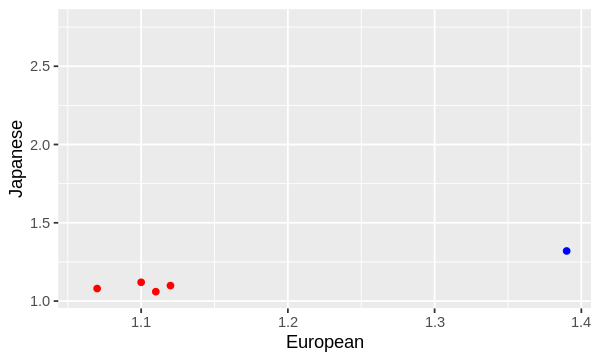

In [35]:
options(repr.plot.width = 5, repr.plot.height = 3)

gwas_df %>%
    select(study = 'STUDY ACCESSION', snp = SNP_ID_CURRENT, odds_ratio = 'OR or BETA',
           p_value = 'P-VALUE', p_value_text = 'P-VALUE (TEXT)') %>%
    filter(is.na(p_value_text) | !str_detect(p_value_text, 'men|female')) %>%
    drop_na(snp) %>%
    mutate(
        population = study %>% recode(
            'GCST008114' = 'African',
            'GCST005047' = 'European',
            'GCST007847' = 'Japanese'
        )
    ) %>%
#     select(population, snp, odds_ratio) %>%
    pivot_wider(id_cols = snp, names_from = population, values_from = odds_ratio) %>%
    ggplot(aes(x = European)) + 
    geom_point(aes(y = Japanese), color = 'red') +
    geom_point(aes(y = African), color = 'blue')

In [36]:
colnames(enrichment_df)

[1] "go_bp"            "bp_genes_refset"  "bp_genes_input"   "expected_genes"  
 [5] "over_under"       "fold_enrichment"  "raw_p_value"      "fdr"             
 [9] "study"            "population"       "gene_type"        "num_genes_input" 
[13] "num_genes_refset"

In [37]:
enrichment_df %>%
mutate(
    population = study %>% recode(
        'GCST008114' = 'African',
        'GCST005047' = 'European',
        'GCST007847' = 'Japanese'
    )
) %>%
filter(gene_type == 'mapped') %>%
pivot_wider(id_cols = go_bp, names_from = population, values_from = fold_enrichment) %>%
# ggplot(aes(x = European, y = Japanese)) + 
# geom_point()
head

go_bp,European,Japanese,African
<chr>,<chr>,<chr>,<chr>
low-density lipoprotein particle receptor biosynthetic process (GO:0045713),> 100,> 100,< 0.01
negative regulation of pancreatic stellate cell proliferation (GO:2000230),> 100,> 100,< 0.01
negative regulation of branching morphogenesis of a nerve (GO:2000173),> 100,< 0.01,< 0.01
negative regulation of neuron remodeling (GO:1904800),> 100,< 0.01,< 0.01
regulation of neuron remodeling (GO:1904799),> 100,< 0.01,< 0.01
regulation of pronephros size (GO:0035565),> 100,> 100,< 0.01


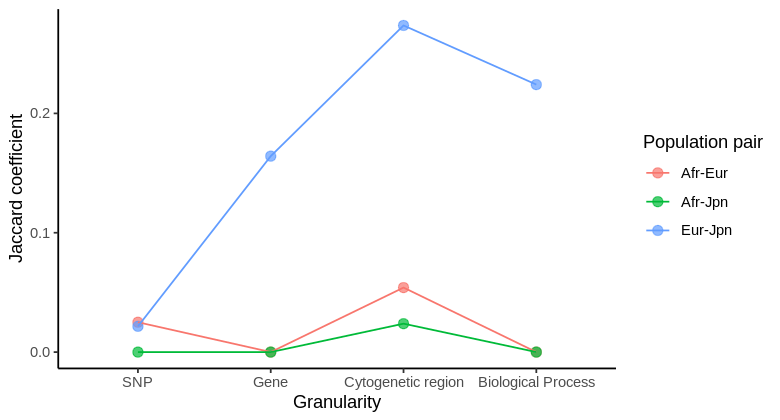

In [38]:
options(repr.plot.width = 6.5, repr.plot.height = 3.5)

data.frame(
    pop = c('Afr-Eur', 'Eur-Jpn', 'Afr-Jpn', 
            'Afr-Eur', 'Eur-Jpn', 'Afr-Jpn',
            'Afr-Eur', 'Eur-Jpn', 'Afr-Jpn',
            'Afr-Eur', 'Eur-Jpn', 'Afr-Jpn'),
    x = c('SNP', 'SNP', 'SNP', 
          'Gene', 'Gene', 'Gene', 
          'Cytogenetic region', 'Cytogenetic region', 'Cytogenetic region', 
          'Biological Process', 'Biological Process', 'Biological Process'),
    y = c(1 / 40, 3 / 139, 0,
          0, 22 / 134, 0,
          2 / 37, 26 / (11 + 26 + 58), 2 / (58 + 26),
          0, 26 / (27 + 26 + 63), 0
          )
) %>%
ggplot(aes(x = factor(x, levels = c('SNP', 'Gene', 'Cytogenetic region', 'Biological Process')), y = y, color = pop, group = pop)) +
geom_point(size = 2.5, alpha = 0.7) +
geom_line() +
theme_classic() +
xlab('Granularity') +
ylab('Jaccard coefficient') +
scale_color_discrete(name = 'Population pair') +
ggsave('../img/jaccard_vs_gran.png', width = 6.5, height = 3.5, dpi = 600)